# Modules

In [1]:
import xarray as xr
import pandas as pd

from pathlib import Path
from scipy.ndimage import label, maximum_filter, binary_erosion
from scipy.interpolate import griddata
from scipy.spatial import ConvexHull

import sys, os, re
import numpy as np      
from netCDF4 import Dataset    
from scipy.spatial import cKDTree

import matplotlib.pyplot as plt       
from matplotlib.patches import Patch

from pyproj import Geod
import cartopy.crs as ccrs                              
import cartopy.feature as cfeature         
import cartopy.io.shapereader as shpreader 

from matplotlib.colors import ListedColormap, BoundaryNorm

from datetime import datetime, timedelta

--------------------------------------------------------------------------
detected:

  Local host:            host839
  Device name:           mlx5_bond_0
  Device vendor ID:      0x02c9
  Device vendor part ID: 4127

Default device parameters will be used, which may result in lower
performance.  You can edit any of the files specified by the
btl_openib_device_param_files MCA parameter to set values for your
device.

NOTE: You can turn off this warning by setting the MCA parameter
      btl_openib_warn_no_device_params_found to 0.
--------------------------------------------------------------------------
--------------------------------------------------------------------------
No OpenFabrics connection schemes reported that they were able to be
used on a specific port.  As such, the openib BTL (OpenFabrics
support) will be disabled for this port.

  Local host:           host839
  Local device:         mlx5_bond_0
  Local port:           1
  CPCs attempted:       rdmacm, udcm
-------

# WS extent

In [2]:
CONTEXT_LAT_MIN = 5
CONTEXT_LAT_MAX = 20
CONTEXT_LON_MIN = -20
CONTEXT_LON_MAX = -4

# Data loading

## Load core

In [3]:
def load_core(t):

    year   = int(t["year"])
    month  = f"{int(t['month']):02d}"
    day    = f"{int(t['day']):02d}"
    hour   = f"{int(t['hour']):02d}"
    minute = f"{int(t['minute']):02d}"

    if year <= 2024:

        base = f"/gws/nopw/j04/cocoon/SSA_domain/ch9_wavelet/{year}/{month}"
        fname = f"{year}{month}{day}{hour}{minute}.nc"
        path = os.path.join(base, fname)

        with Dataset(path) as ds:
            cores = ds["cores"][0]

            Pmax_lat = ds["max_lat"][:]
            Pmax_lon = ds["max_lon"][:]

        geo = np.load("/gws/nopw/j04/cocoon/SSA_domain/lat_lon_2268_2080.npz")
        lons = geo["lon"]
        lats = geo["lat"]

    else:

        base = f"/gws/ssde/j25b/swift/rt_cores/{year}/{month}/{day}/{hour}{minute}"
        fname = f"Convective_struct_extended_{year}{month}{day}{hour}{minute}_000.nc"
        path = os.path.join(base, fname)

        with Dataset(path) as ds:
            cores = ds["cores"][:]

            Pmax_lat = ds["Pmax_lat"][:]
            Pmax_lon = ds["Pmax_lon"][:]

        geo = Dataset(
            "/gws/ssde/j25b/swift/rt_cores/geoloc_grids/"
            "nxny2268_2080_nxnyds164580_blobdx0.04491576_arean41_n27_27_79.nc"
        )
        lons = geo["lons_mid"][:]
        lats = geo["lats_mid"][:]
        geo.close()

    # ensure 1D arrays for matching
    Pmax_lat = np.asarray(Pmax_lat).ravel()
    Pmax_lon = np.asarray(Pmax_lon).ravel()

    return cores, lats, lons, Pmax_lat, Pmax_lon

## Load RoA

In [4]:
def load_roa(t):

    year   = f"{int(t['year']):04d}"
    month  = f"{int(t['month']):02d}"
    day    = f"{int(t['day']):02d}"
    hour   = f"{int(t['hour']):02d}"
    minute = f"{int(t['minute']):02d}"

    base = Path("/gws/ssde/j25b/swift/RoA")

    t0 = datetime(int(year), int(month), int(day),
                  int(hour), int(minute))
    t1 = t0 + timedelta(minutes=15)

    # Try MSG4 first, then MSG3
    candidates = []
    for sat in ["MSG4", "MSG3"]:
        fname = (
            f"{sat}{t0:%Y%m%d}"
            f"-S{t0:%H%M}"
            f"-E{t1:%H%M}.nc"
        )
        candidates.append(base / year / month / fname)

    path = next((p for p in candidates if p.exists()), None)

    if path is None:
        print("No RoA file found for this time")
        return None, None, None

    with Dataset(path) as ds:

        lat = ds.variables["latitude"][:]
        lon = ds.variables["longitude"][:]

        var = ds.variables["posterior_mean"]
        roa = var[:]

        if hasattr(var, "scale_factor"):
            scale = var.scale_factor
            offset = getattr(var, "add_offset", 0.0)
            roa = roa * scale + offset

        roa = np.ma.filled(roa, np.nan)

    lons, lats = np.meshgrid(lon, lat)

    return roa, lats, lons


# Load data for comparison

## Choose time

In [5]:
from datetime import datetime, timedelta

def generate_time_steps(start, end, step_minutes=15):
    """
    Generate time steps between start and end (inclusive)
    as dictionaries with keys: year, month, day, hour, minute.

    Parameters
    ----------
    start : dict
        e.g. dict(year=2020, month=7, day=5, hour=12, minute=15)
    end : dict
        Same format as start
    step_minutes : int
        Time step in minutes (default 15)

    Returns
    -------
    list of dict
    """

    start_dt = datetime(
        start["year"], start["month"], start["day"],
        start["hour"], start["minute"]
    )

    end_dt = datetime(
        end["year"], end["month"], end["day"],
        end["hour"], end["minute"]
    )

    step = timedelta(minutes=step_minutes)

    times = []
    current = start_dt

    while current <= end_dt:
        times.append(
            dict(
                year=current.year,
                month=current.month,
                day=current.day,
                hour=current.hour,
                minute=current.minute,
            )
        )
        current += step

    return times

In [6]:
t = dict(year=2020, month=7, day=5, hour=12, minute=15)

## Load both data

In [7]:
data_core, lats_core, lons_core, Pmax_lat, Pmax_lon = load_core(t)
data_roa, lats_roa, lons_roa = load_roa(t)

# Domain cropping

## Utilities for cropping

In [8]:
class GeoGrid:

    def __init__(
        self,
        lats,
        lons,
        lat_min,
        lat_max,
        lon_min,
        lon_max,
        fill_value=-999.999
    ):

        self.fill_value = fill_value

        self.lats, self.lons, self.area, self.y0, self.y1, self.x0, self.x1 = \
            self._crop_with_area(
                lats, lons,
                lat_min, lat_max,
                lon_min, lon_max
            )

        self.Ny, self.Nx = self.lats.shape

        points = np.column_stack([
            self.lats.ravel(),
            self.lons.ravel()
        ])

        self.tree = cKDTree(points)


    def _crop_with_area(
        self,
        lats,
        lons,
        lat_min,
        lat_max,
        lon_min,
        lon_max
    ):

        lats_nan = np.where(lats == self.fill_value, np.nan, lats)
        lons_nan = np.where(lons == self.fill_value, np.nan, lons)

        mask = (
            (lats_nan >= lat_min) &
            (lats_nan <= lat_max) &
            (lons_nan >= lon_min) &
            (lons_nan <= lon_max)
        )

        rows = np.where(mask.any(axis=1))[0]
        cols = np.where(mask.any(axis=0))[0]

        y0, y1 = rows[0], rows[-1]
        x0, x1 = cols[0], cols[-1]

        lats_crop = lats[y0:y1+1, x0:x1+1]
        lons_crop = lons[y0:y1+1, x0:x1+1]

        R = 6371.0

        lat_rad = np.deg2rad(lats_crop)
        lon_rad = np.deg2rad(lons_crop)

        dlat = np.gradient(lat_rad, axis=0)
        dlon = np.gradient(lon_rad, axis=1)

        dy = R * dlat
        dx = R * np.cos(lat_rad) * dlon

        area = np.abs(dx * dy)

        return lats_crop, lons_crop, area, y0, y1, x0, x1


    def crop(self, field):
        return field[self.y0:self.y1+1, self.x0:self.x1+1]


    def query(self, lat, lon):
        _, idx = self.tree.query([lat, lon])
        return np.unravel_index(idx, (self.Ny, self.Nx))

    def query_many(self, lat, lon):
        pts = np.column_stack([lat, lon])
        _, idx = self.tree.query(pts)
        return np.unravel_index(idx, (self.Ny, self.Nx))

## Crop RoA and core data

In [9]:
extent = (
    CONTEXT_LAT_MIN, CONTEXT_LAT_MAX,
    CONTEXT_LON_MIN, CONTEXT_LON_MAX
)

grid_core = GeoGrid(lats_core, lons_core, *extent)
grid_roa  = GeoGrid(lats_roa,  lons_roa,  *extent)

# crop data
data_core = grid_core.crop(data_core)
data_roa  = grid_roa.crop(data_roa)

# use cropped coordinates from grid
lats_core = grid_core.lats
lons_core = grid_core.lons

lats_roa  = grid_roa.lats
lons_roa  = grid_roa.lons

In [10]:
assert data_core.shape == lats_core.shape == lons_core.shape 
assert data_roa.shape == lats_roa.shape == lons_roa.shape 

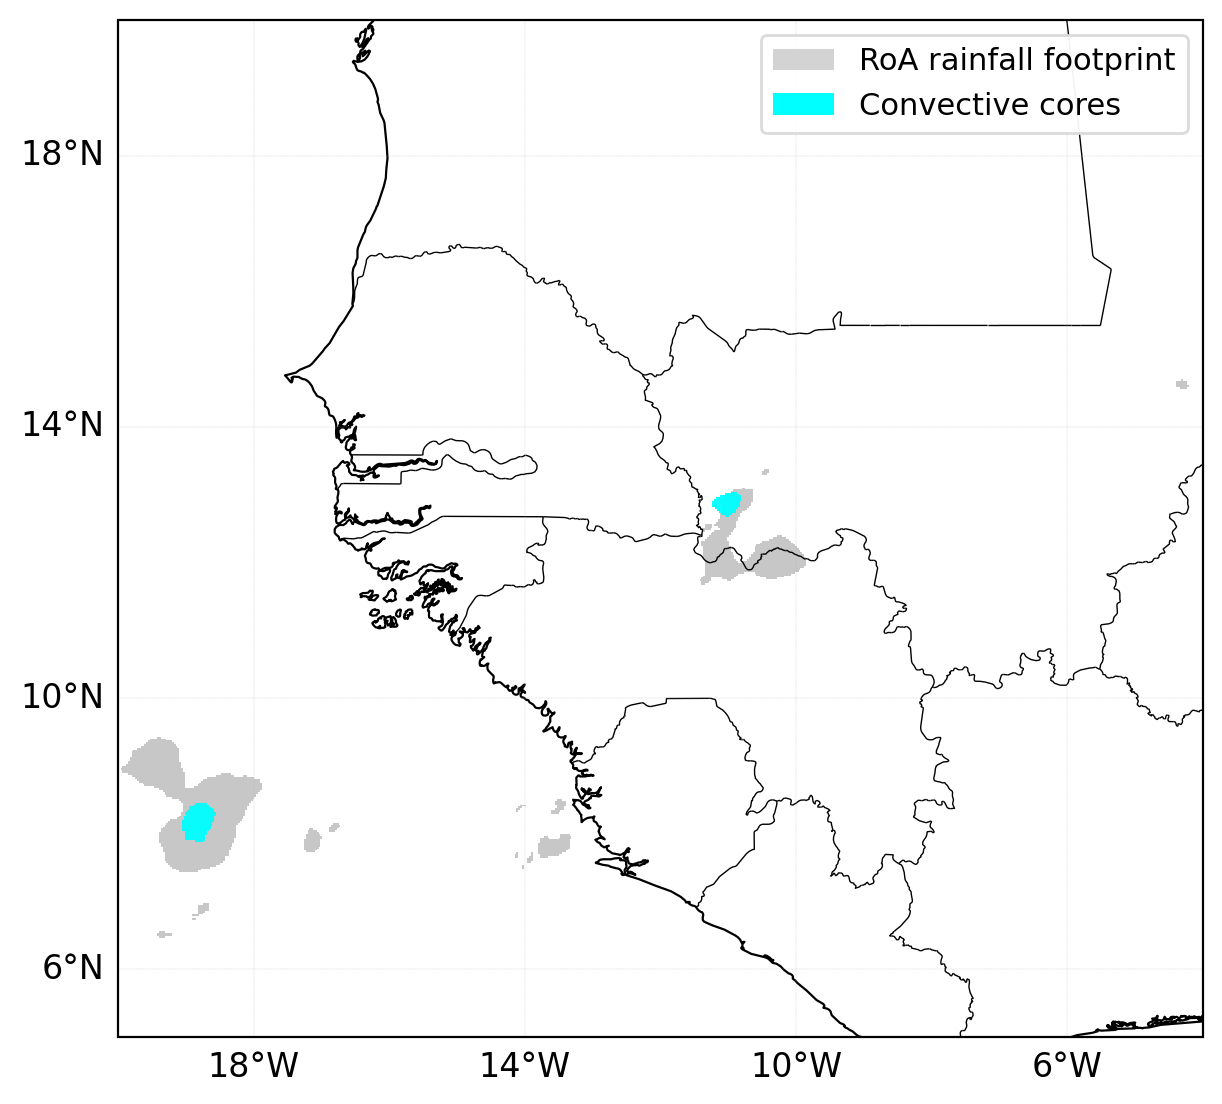

In [11]:
threshold_roa = 2.92
threshold_core = 10

# nan to make the plotting faster
mask_roa  = np.where(data_roa > threshold_roa, 1, np.nan)
mask_core = np.where(data_core > threshold_core, 1, np.nan)

proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(7, 7), dpi=200)
ax = plt.axes(projection=proj)

ax.coastlines(resolution="10m", linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)

ax.set_extent(
    [CONTEXT_LON_MIN, CONTEXT_LON_MAX,
     CONTEXT_LAT_MIN, CONTEXT_LAT_MAX],
    crs=proj
)

gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.1,
                  xlocs=np.arange(-18, 6, 4),
                  ylocs=np.arange(6, 20, 4))

gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {"size": 12}
gl.ylabel_style = {"size": 12}


# RoA rainfall footprint
ax.pcolormesh(
    lons_roa,
    lats_roa,
    mask_roa,
    shading="nearest",
    cmap=ListedColormap(["#c7c7c7"]),
    alpha=1,
    transform=proj
)

# Convective cores
ax.pcolormesh(
    lons_core,
    lats_core,
    mask_core,
    shading="nearest",
    cmap=ListedColormap(["cyan"]),
    alpha=0.95,
    transform=proj
)

legend_elements = [
    Patch(facecolor="lightgrey", edgecolor="none", label="RoA rainfall footprint"),
    Patch(facecolor="cyan", edgecolor="none", label="Convective cores"),
]

ax.legend(
    handles=legend_elements,
    loc="upper right",
    framealpha=0.95,
    edgecolor="0.85",
    fontsize=11
)

plt.show()

# Extract objects from fields

In [12]:
import numpy as np
import pandas as pd
from scipy.ndimage import label


def field_to_objects(
    field,
    threshold,
    grid,
    name="field",
    connectivity=8,
    min_area_km2=0.0,
    min_pixels=0
):
    # extract connected objects above a threshold and compute area, centroid, intensity, elongation, and eccentricity
    mask = field >= threshold

    if not np.any(mask):
        return pd.DataFrame()

    if connectivity == 8:
        structure = np.ones((3, 3))
    else:
        structure = None

    labeled, n = label(mask, structure=structure)

    rows = []

    for lab in range(1, n + 1):

        m = labeled == lab
        n_pix = int(np.sum(m))

        if n_pix < min_pixels:
            continue

        weights = grid.area[m]
        size_km2 = float(np.sum(weights))

        if size_km2 < min_area_km2:
            continue

        lat_vals = grid.lats[m]
        lon_vals = grid.lons[m]

        lat_centroid = float(np.average(lat_vals, weights=weights))
        lon_centroid = float(np.average(lon_vals, weights=weights))

        mean_val = float(np.nanmean(field[m]))
        max_val = float(np.nanmax(field[m]))

        coords = np.column_stack((lat_vals, lon_vals))
        cov = np.cov(coords, rowvar=False, aweights=weights)

        eigvals, _ = np.linalg.eigh(cov)

        major = np.sqrt(max(eigvals.max(), 0.0))
        minor = np.sqrt(max(eigvals.min(), 0.0))

        elongation = float(major / (minor + 1e-12))

        eccentricity = float(
            np.sqrt(max(0.0, 1.0 - (minor**2 / (major**2 + 1e-12))))
        )

        rows.append((
            lab,
            lat_centroid,
            lon_centroid,
            size_km2,
            n_pix,
            mean_val,
            max_val,
            elongation,
            eccentricity
        ))

    return pd.DataFrame(
        rows,
        columns=[
            "label",
            "lat_centroid",
            "lon_centroid",
            "size",
            "n_pix",
            f"mean_{name}",
            f"max_{name}",
            "elongation",
            "eccentricity"
        ]
    )

In [13]:
df_core = field_to_objects(
    field=data_core,
    threshold=threshold_core,
    connectivity=4,
    grid=grid_core,
    name="core"
)

df_core

,label,lat_centroid,lon_centroid,size,n_pix,mean_core,max_core,elongation,eccentricity
0,1,8.171836,-18.818010,2570.142090,253,123.110672,184.0,1.415939,0.707967
1,2,12.868172,-11.009824,1260.923584,129,170.186047,270.0,1.332190,0.660707


In [14]:
df_roa = field_to_objects(
    field=data_roa,
    threshold=threshold_roa,
    connectivity=8,
    grid=grid_roa,
    name="roa"
)

df_roa

,label,lat_centroid,lon_centroid,size,n_pix,mean_roa,max_roa,elongation,eccentricity
0,1,6.511313,-19.322112,197.276553,22,3.427554,4.056473,2.364183e+00,0.906139
1,2,6.740966,-18.878782,17.925885,2,2.947144,2.953040,1.910411e+10,1.000000
2,3,6.880272,-18.760585,286.730779,32,3.078715,3.278906,2.159216e+00,0.886290
3,4,8.396502,-18.882686,23213.413027,2600,5.435727,17.016244,1.431424e+00,0.715507
4,5,7.510976,-14.029179,17.895792,2,3.020869,3.085660,1.910454e+10,1.000000
5,6,7.632553,-13.916608,107.344444,12,3.190962,3.498924,2.492801e+00,0.916010
6,7,7.681188,-14.121038,44.721756,5,3.205831,3.626216,1.732049e+00,0.816496
7,8,7.820851,-13.570382,1484.268198,166,4.581923,8.150355,1.785138e+00,0.828370
8,9,7.891625,-17.133894,849.285746,95,3.441361,3.995621,1.424114e+00,0.711989
9,10,8.093209,-16.807909,178.708881,20,3.169554,3.598418,1.787464e+00,0.828863
